


![Мощный заголовок]( ) 




## 1. Подготовка

Многие сайты и сервисы хотят упростить жизнь программистам и предоставляют им в пользование уже готорвые куски кода, к которым можно просто обратиться и получить нужную инфомрацию о сервисе. Такие куски кода называются API (Application programming interface). Мы уже пользовались с вами API Google maps, когда качали цены домиков с ЦИАН. Теперь пришло время сделать то же самое с контактом! API это чуть ли не единственный способ добиться чего-либо от него. Ознакомиться с спсобами такого взаимодействия с вконтакте можно [по ссылке, о существовании которой вы даже не догадывались...](https://vk.com/dev/manuals) Да, да, это документация для разработчиков...

Для того, чтобы получить доступ к выгрузке данных из вконтакте, нужно пройти ряд бюрократических процедур. А именно, получить ключ доступа - access token. Для этого:

Создаем свое приложение. Заполняем все поля, загружаем предварительно подготовленные картинки нужного размера. Разрешаем доступ этому приложению к своей старнцие. Сделать это можно по ссылке: http://vk.com/editapp?act=create.

![два скрина с руководством]()

Для работы с частью методов API вконтакте этого вполне достаточно (обычно в заголовке такого метода стоит соответствующая пометка). Для части методов, испульзуемых нами, может понадобиться ключ доступа.

Для того, чтобы получить его необходимо сделать ещё пару странных манипуляций:

Переходим по ссылке вида:

> https://oauth.vk.com/authorize?client_id=**********&scope=friends&redirect_uri=https://oauth.vk.com/blank.html&display=page&v=5.16&response_type=token


>https://oauth.vk.com/authorize?client_id=4887677&scope=friends&redirect_uri=https://oauth.vk.com/blank.html&display=page&v=5.16&response_type=token

На месте звездочек должен стоять ID созданного вами приложения.

В итоге по этому запросу будет сформирована ссылка следующего вида:

> https://oauth.vk.com/blank.html#access_token=95b636116ef20e0798fe4dff380511fc13&expires_in=86400&user_id=6045249


Первый набор знаков - access token, т.е. маркер доступа. Вторая цифра (expires_in=) время работы маркера доступа в секундах (одни сутки). По истечению суток нужно будет получить новый маркер доступа. Последняя цифра (user_id=) ваш ID Вконтакте. Нам в дальнейшем понадобится маркер доступа и ID.  Для удобства сохраним их.

In [1]:
token="5f686efffff8f4d7e10e263650bbb57c85773298165fb4669dc3d8d449178fbe761547fb25888016c42e9"
myid ="6045249"

## 2. Честный сбор данных.

In [29]:
# Подгружаем уже знакомую нам библиотеку для запросов
import requests
# Подгружаем библиотеку для работы с матрицами и векторами
import numpy as np

Подробно узнать о том как задать вопрос Вконтакте можно по этой ссылке: https://new.vk.com/dev/api_requests. Как это можно выяснить по ссылке, любой запрос к Вконтакте должен иметь структуру следующего вида:

> https://api.vk.com/method/METHOD_NAME?PARAMETERS&access_token=ACCESS_TOKEN&v=V 

По аналогии с Google maps в ссылку сначала встраивается метод, с помощью которого мы осуществляем запрос и какие-то параметры для этого метода. 

Список всех существующих методов и параметров для них можно изучить по ссылке  https://vk.com/dev/methods.

Попробуем узнать своё имя. В списке методов можно узнать, что метод "users.get"  возвращает расширенную информацию о пользователе. Параметр user_ids отвечает за id польователей, о которых информацию нам хотелось бы вытащить.

In [3]:
url = "https://api.vk.com/method/users.get?user_ids=6045249&access_token="+str(token)

In [4]:
response = requests.get(url) 
response

<Response [200]>

Ура! Благославенный 200-ответ! Мы получили его в json формате по аналогии с Google-maps. Посмотрим что у нас тут...

In [5]:
my_name = response.json()
my_name

{'response': [{'first_name': 'Филипп',
   'last_name': 'Ульянкин',
   'uid': 6045249}]}

О боже! Это же питонячий словарь! 

In [6]:
infa = my_name['response'][0]
infa

{'first_name': 'Филипп', 'last_name': 'Ульянкин', 'uid': 6045249}

In [7]:
infa['first_name'] + ' ' + infa['last_name']

'Филипп Ульянкин'

Для того, чтобы узнать своё имя, нам потребовалась самая малость... Около 10 строк кода... Напишем функцию, которая поможет нам в дальнейшем тащить из вконтакте нужную информацию и перейдём к решению серьёзных проблем.

In [8]:
def Vk_downloader(method,parameters,token = token):
    url = 'https://api.vk.com/method/'+method+'?'+parameters+'&access_token='+str(token)
    response = requests.get(url) 
    return(response.json())

Vk_downloader('users.get','user_ids=6045249')

{'response': [{'first_name': 'Филипп',
   'last_name': 'Ульянкин',
   'uid': 6045249}]}

## 3. Как распределены лайки?

### 3.1 Скачиваем лайки

Вам когда-нибудь было интересно какое распределение у лайков? Пришло время получить ответ на этот вопрос! На самом деле ответ очевиден. Попробуйте угадать...

Для начала выгрузим пару записей со своей стены, чтобы проверить работает ли команда. В качестве ответа на запрос мы получим длинный страшный кусок текста. В этом куске текста будет абсолютно все, что есть у нас на стене. Ссылки на картинки, количество лайков под каждой записью, подробная история того как и откуда был сделан репост записи и так далее. Нас будет интересовать среди всего этого огромного массива данных только одно число - количество лайков под каждой записью, которое будет идити после слова "likes". Вытащим два поста со своей стены и узнаем сколько под ними лайков.

In [9]:
wall = Vk_downloader('wall.get','user_ids=6045249')
wall

{'response': [128,
  {'attachment': {'link': {'description': '',
     'image_big': 'https://pp.userapi.com/c637125/v637125211/4a631/erB8NruZGbM.jpg',
     'image_src': 'https://pp.userapi.com/c637125/v637125211/4a62f/dd-mIfW5B6s.jpg',
     'preview_page': '1148727013_1565611111',
     'preview_url': 'https://m.vk.com/article1148727013_1565611111?api_view=066215601cafa2506cbbc3e2b216da',
     'target': 'external',
     'title': 'Что делают с пятиэтажками в Европе: реконструкция вместо реновации',
     'url': 'http://varlamov.ru/2359727.html'},
    'type': 'link'},
   'attachments': [{'link': {'description': '',
      'image_big': 'https://pp.userapi.com/c637125/v637125211/4a631/erB8NruZGbM.jpg',
      'image_src': 'https://pp.userapi.com/c637125/v637125211/4a62f/dd-mIfW5B6s.jpg',
      'preview_page': '1148727013_1565611111',
      'preview_url': 'https://m.vk.com/article1148727013_1565611111?api_view=066215601cafa2506cbbc3e2b216da',
      'target': 'external',
      'title': 'Что делаю

In [10]:
len(wall['response'])

21

Скачалось целых 20 записей. Первая запись - число постов на стене. Посмотрим на парочку.

In [11]:
wall['response'][1]

{'attachment': {'link': {'description': '',
   'image_big': 'https://pp.userapi.com/c637125/v637125211/4a631/erB8NruZGbM.jpg',
   'image_src': 'https://pp.userapi.com/c637125/v637125211/4a62f/dd-mIfW5B6s.jpg',
   'preview_page': '1148727013_1565611111',
   'preview_url': 'https://m.vk.com/article1148727013_1565611111?api_view=066215601cafa2506cbbc3e2b216da',
   'target': 'external',
   'title': 'Что делают с пятиэтажками в Европе: реконструкция вместо реновации',
   'url': 'http://varlamov.ru/2359727.html'},
  'type': 'link'},
 'attachments': [{'link': {'description': '',
    'image_big': 'https://pp.userapi.com/c637125/v637125211/4a631/erB8NruZGbM.jpg',
    'image_src': 'https://pp.userapi.com/c637125/v637125211/4a62f/dd-mIfW5B6s.jpg',
    'preview_page': '1148727013_1565611111',
    'preview_url': 'https://m.vk.com/article1148727013_1565611111?api_view=066215601cafa2506cbbc3e2b216da',
    'target': 'external',
    'title': 'Что делают с пятиэтажками в Европе: реконструкция вместо рен

In [12]:
wall['response'][1]['likes']

{'can_like': 1, 'can_publish': 0, 'count': 14, 'user_likes': 0}

In [13]:
wall['response'][1]['likes']['count']

14

In [14]:
[item['likes']['count'] for item in wall['response'][1:]]


[14, 4, 12, 2, 11, 12, 7, 27, 7, 12, 2, 14, 1, 5, 8, 4, 19, 7, 10, 2]

Все лайки со стены в наших руках! Можно творить с ними что угодно... Попробуем провернуть аналогичный трюк с лайками из какой-нибудь группы. Например, лентача. Отметим, что при этом есть одна тонкость, которая прописана в описании метода "wall.get". Если мы хотим вытащить записи из группы, то ее id должен быть записан со знаком минус.


In [15]:
wall = Vk_downloader('wall.get','owner_id=-29534144')
wall

{'response': [20969,
  {'attachment': {'photo': {'access_key': 'fc1f5d1e287f6c1122',
     'aid': -7,
     'created': 1494428411,
     'height': 359,
     'owner_id': -29534144,
     'pid': 456377343,
     'post_id': 6271865,
     'src': 'https://pp.userapi.com/c7002/v7002865/30e7b/OcX16cLJrfI.jpg',
     'src_big': 'https://pp.userapi.com/c7002/v7002865/30e7c/qDpqL1dXNbY.jpg',
     'src_small': 'https://pp.userapi.com/c7002/v7002865/30e7a/NDsL3t1RFpc.jpg',
     'text': 'В Венесуэле оппозиция планирует провести «Марш дерьма» и закидать правительство говном. Прям буквально говном.<br><br>Протестующие подготавливают «коктейли Калотова» и намерены выступить против президента страны<br><br>http://news.lenta.ch/tuLp',
     'user_id': 100,
     'width': 502},
    'type': 'photo'},
   'attachments': [{'photo': {'access_key': 'fc1f5d1e287f6c1122',
      'aid': -7,
      'created': 1494428411,
      'height': 359,
      'owner_id': -29534144,
      'pid': 456377343,
      'post_id': 6271865,
    

Запилим функцию для выкачивания лайков.

In [16]:
def Likes(wall):
    return([item['likes']['count'] for item in wall['response'][1:]])

In [17]:
len(Likes(wall))

20

У нас уже есть 20 лайков. Хотелось бы получить побольше. Изучаем документацию. Выясняем, что существуют такие параметры как `count` - число записей для скачки (не может превышать 100) и `offset` - смещение, необходимое для выборки определённого подмножества записей. 

Модернизируем запрос.

In [18]:
print( Vk_downloader('wall.get','owner_id=-29534144&count=1'),
      Vk_downloader('wall.get','owner_id=-29534144&count=1&offset=1'),
      sep = '\n \n \n')

{'response': [20969, {'online': 0, 'from_id': -29534144, 'attachment': {'photo': {'text': 'В Венесуэле оппозиция планирует провести «Марш дерьма» и закидать правительство говном. Прям буквально говном.<br><br>Протестующие подготавливают «коктейли Калотова» и намерены выступить против президента страны<br><br>http://news.lenta.ch/tuLp', 'src_big': 'https://pp.userapi.com/c7002/v7002865/30e7c/qDpqL1dXNbY.jpg', 'src': 'https://pp.userapi.com/c7002/v7002865/30e7b/OcX16cLJrfI.jpg', 'aid': -7, 'src_small': 'https://pp.userapi.com/c7002/v7002865/30e7a/NDsL3t1RFpc.jpg', 'height': 359, 'created': 1494428411, 'pid': 456377343, 'owner_id': -29534144, 'post_id': 6271865, 'width': 502, 'user_id': 100, 'access_key': 'fc1f5d1e287f6c1122'}, 'type': 'photo'}, 'text': 'В Венесуэле оппозиция планирует провести «Марш дерьма» и закидать правительство говном. Прям буквально говном.<br><br>Протестующие подготавливают «коктейли Калотова» и намерены выступить против президента страны<br><br>http://news.lenta.c

Скачиваем 20 000 лоисов!

![картинка с лайками]()

In [19]:
list(range(0,20100,100))[:10]

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900]

In [20]:
likes = [ ]

for i in range(0,20100,100):
    wall =  Vk_downloader('wall.get','owner_id=-29534144&count=100&offset='+str(i))
    likes.extend(Likes(wall))
    if i%1000 == 0:
        print(i)

len(likes)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


20100

Итак, наконец-то 20 100 лайков в наших руках. Отбросим первые сто постов, под которыми лайки ещё продолжают ставится и исследуем 20 000 лайков!

### 3.2 Изучаем лайки

In [21]:
import scipy.stats as sts  # Пакет для статистики

In [23]:
import matplotlib.pyplot as plt # Пакет для визуализации
# Опция для отображения картинок
%matplotlib inline 
# Размер картинок
plt.figure(figsize=(20,10))

Откинем первые сто постов, под которыми лайки всё ещё ставятся, превратим вектор в нумпаевский и посчитаем какие-нибудь описательные статистики.

In [24]:
likes = likes[100:]

In [27]:
likes[:10]

[1831, 6642, 5975, 8840, 2873, 1754, 5715, 4168, 6545, 5373]

Если вы до этого момента никогда не встречали нумпай, то выглядит он примерно уот так уот...

In [30]:
likes = np.array(likes)
likes[:10]

array([1831, 6642, 5975, 8840, 2873, 1754, 5715, 4168, 6545, 5373])

In [36]:
print('Среднее число лайков: ',np.mean(likes))
print('Минимальное число лайков: ',np.min(likes))
print('Максимальное число лайков: ',np.max(likes))
print('Медианное число лайков: ',np.median(likes))
print('Дисперсия числа лайков: ',np.var(likes))
print('Всего лайков: ',np.sum(likes))

Среднее число лайков:  3953.601
Минимальное число лайков:  0
Максимальное число лайков:  48630
Медианное число лайков:  3448.0
Дисперсия числа лайков:  7956684.1537
Всего лайков:  79072020


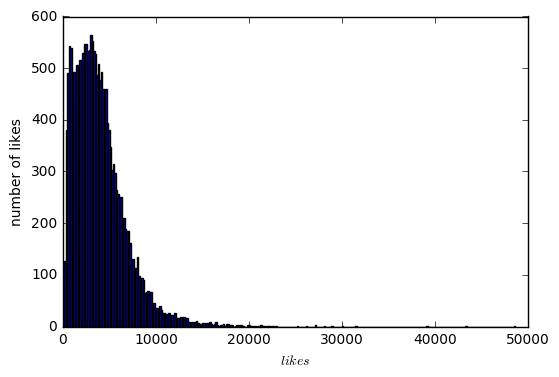

In [48]:
plt.hist(likes,bins=300)
plt.ylabel('number of likes')
plt.xlabel('$likes$')

In [181]:
# Гипотеза о пуассоне...
x = np.random.poisson(10,1000)
y = np.random.poisson(9.9,1000)
sts.ks_2samp(x,y)

Ks_2sampResult(statistic=0.013999999999999957, pvalue=0.99996878255929322)

In [180]:
# Гипотеза не прошла :(
sravn = np.random.poisson(np.mean(likes),20000)
sts.ks_2samp(sravn,likes)

Ks_2sampResult(statistic=0.54949999999999999, pvalue=0.0)

In [179]:
# Да и фиг с ним! Построи бутстраповский доверительный интервал и забьём.

def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

stat_intervals(get_bootstrap_samples(likes, 1000),0.05)

array([   482.,  10792.])

Количество лайков под постом на лентаче с вероятностью 95% окажется в интервале между 482 и 10792. Интервал не очень впечатляет...

Идеи для дальнейшего развития: 
* Что-нибудь с АВ-тестированием. Лайки до развала и после развала.
* В какое время чаще всего делаются посты на лентаче?
* Пост, сделанный в какое время набирает наибольшее число лайков?

## 4. Реализация какой-нибудь идеи, но не первой

## 5. Читерский способ скачивать контакт

Сейчас мы скачивали из контакта данные напряму обращаясь к API. Стоит заметить, что для работы с конатктом в питоне существует специальный пакет. Установить его можно прописав `pip3 install vk`. 

Подробнее узнать про этот модуль можно в документации: https://pypi.python.org/pypi/vk/1.5

Мы не будем использовать его в наших скриптах. Потому что мы жёсткие. 

![картинка, показывающая нашу силу]()
